In [7]:
### MAKING A BRIDGE

Nx = 15
Ny = 7

# FIXED NODES
fixed = [ sub2ind((Nx,Ny),1,1), sub2ind((Nx,Ny),Nx,1)]

# uniform load
loaded = [ (sub2ind((Nx,Ny),j,1), 0,1) for j = 1:Nx ]

# point load
# loaded = [ (sub2ind((Nx,Ny),Int((Nx+1)/2),1), 0,Nx) ];

In [3]:
### MAKING A TOWER

Nx = 8
Ny = 15

# FIXED NODES
fixed = [ sub2ind((Nx,Ny),i,1) for i = 3:6 ]

# crunching
# loaded = [ (sub2ind((Nx,Ny),i,Ny), 0,1) for i = 4:5 ]

# # uniform lateral load
loaded1 = [ (sub2ind((Nx,Ny),4,j), 1,0) for j = 1:Ny ];
loaded2 = [ (sub2ind((Nx,Ny),5,j), 1,0) for j = 1:Ny ];
loaded = [loaded1; loaded2]

30-element Array{Tuple{Int64,Int64,Int64},1}:
 (4, 1, 0)  
 (12, 1, 0) 
 (20, 1, 0) 
 (28, 1, 0) 
 (36, 1, 0) 
 (44, 1, 0) 
 (52, 1, 0) 
 (60, 1, 0) 
 (68, 1, 0) 
 (76, 1, 0) 
 (84, 1, 0) 
 (92, 1, 0) 
 (100, 1, 0)
 ⋮          
 (29, 1, 0) 
 (37, 1, 0) 
 (45, 1, 0) 
 (53, 1, 0) 
 (61, 1, 0) 
 (69, 1, 0) 
 (77, 1, 0) 
 (85, 1, 0) 
 (93, 1, 0) 
 (101, 1, 0)
 (109, 1, 0)
 (117, 1, 0)

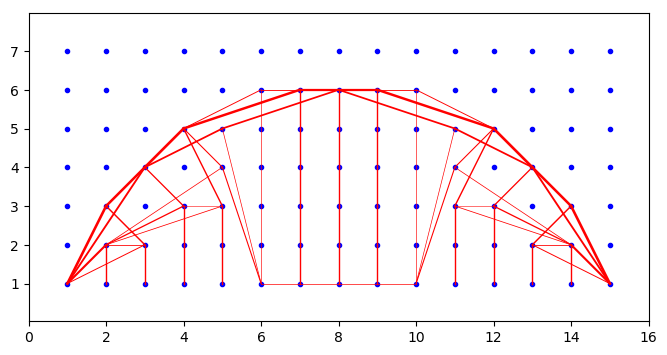

Academic license - for non-commercial use only


In [8]:
N = Nx*Ny  # number of nodes

    # NODES: columns are x and y components respectively
nodes = [ kron(ones(Ny),collect(1:Nx)) kron(collect(1:Ny),ones(Nx)) ]

M = Int(N*(N-1)/2)  # number of edges

# EDGES: columns are the indices of the nodes at either end
edges = Array{Int}(zeros(M,2))

k = 0
for i = 1:N
    for j = 1:i-1
        k = k+1
        edges[k,:] = [i j]
    end
end

ℓ = zeros(M)
nx = zeros(N,M)
ny = zeros(N,M)
for j = 1:M
    i1 = edges[j,1]
    i2 = edges[j,2]
    ℓ[j] = norm( [nodes[i1,1]-nodes[i2,1], nodes[i1,2]-nodes[i2,2]] )
    nx[i1,j] = (nodes[i1,1]-nodes[i2,1])/ℓ[j]
    nx[i2,j] = (nodes[i2,1]-nodes[i1,1])/ℓ[j]
    ny[i1,j] = (nodes[i1,2]-nodes[i2,2])/ℓ[j]
    ny[i2,j] = (nodes[i2,2]-nodes[i1,2])/ℓ[j]
end

fx = zeros(N)
fy = zeros(N)
for L in loaded
    ind = L[1]
    fx[ind] = L[2]
    fy[ind] = L[3]
end

using JuMP, Gurobi
m = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m, x[1:M] >= 0)   # area of edge from i to j
@variable(m, u[1:M] )       # force in edge from i to j

for i = 1:N
    if i in fixed
        continue
    else
        @constraint(m, sum(u[j]*nx[i,j] for j=1:M) + fx[i] == 0 )
        @constraint(m, sum(u[j]*ny[i,j] for j=1:M) + fy[i] == 0 )
    end
end

@constraint(m, -x .<= u)
@constraint(m,  u .<= x)

@objective(m, Min, sum(ℓ[j]*x[j] for j=1:M))

solve(m)
xopt = getvalue(x);
uopt = getvalue(u);

using PyPlot

figure(figsize=((Nx+1)/2,(Ny+1)/2))

plot( nodes[:,1], nodes[:,2], "b." )
for j = 1:M
    if xopt[j] > 0
        i1 = edges[j,1]
        i2 = edges[j,2]
        plot( nodes[[i1,i2],1], nodes[[i1,i2],2], "r-", linewidth=sqrt(xopt[j]) )
    end
end
axis("equal")
axis([0,Nx+1,0,Ny+1])
;